In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-3]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [4]:
all_X.condition.unique()

array(['25', '50'], dtype=object)

In [25]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = ["cable+load", "load"]
    labels_50 = ["load", "cable+load"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 25
class
None          317
load          132
cable+load    128
Name: count, dtype: int64

Condition: 50
class
None          392
load          124
cable+load    123
Name: count, dtype: int64


In [26]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
for cond in all_X_clean['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 25
class
load          132
cable+load    128
Name: count, dtype: int64

Condition: 50
class
load          124
cable+load    123
Name: count, dtype: int64



Condition 25 - Data summary by class:
  load: 132 points, time range: 0.0 - 131.0 s
  cable+load: 128 points, time range: 152.0 - 279.0 s

Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  cable+load: 123 points, time range: 144.0 - 266.0 s


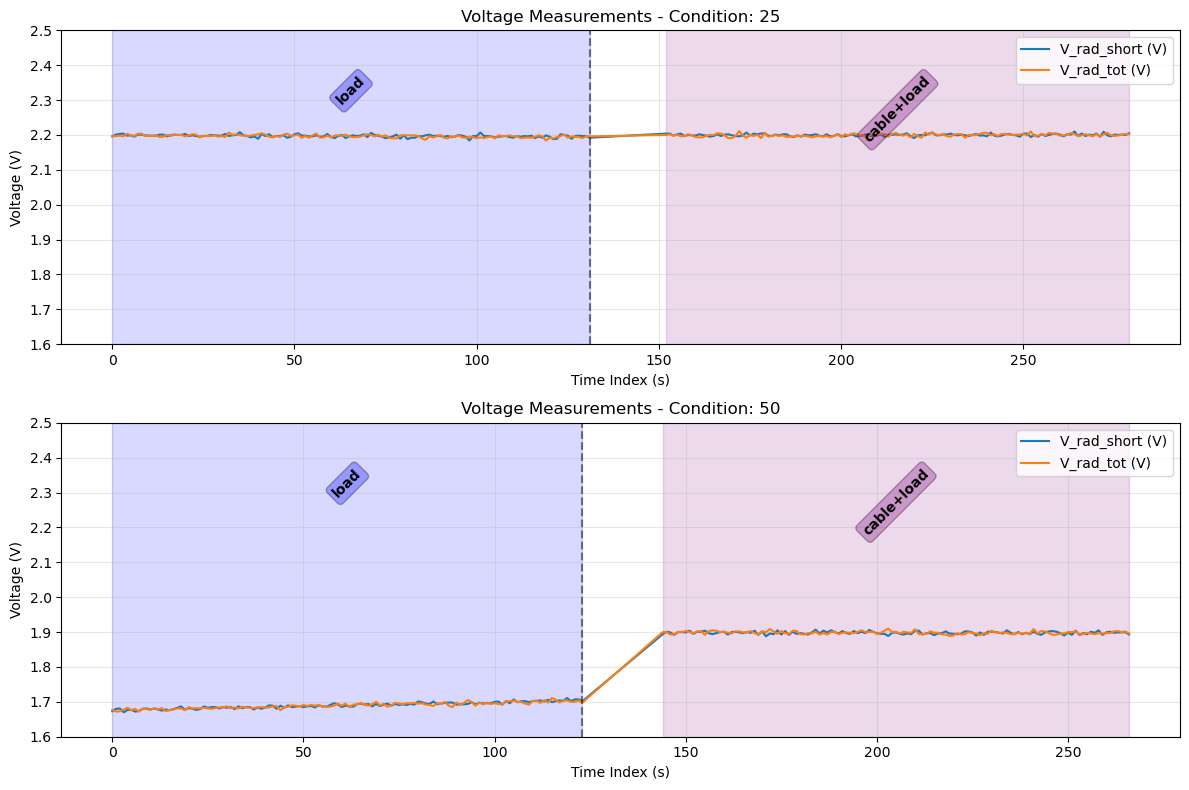

In [27]:
# Define class order and colors
class_order = ['load', 'cable+load']
class_colors = {
    'load': 'blue',
    'cable+load': 'purple',
    # 'cable+antenna': 'purple',
    # 'antenna+cooling': 'brown',
    # 'cable+antenna+cooling': 'pink'
}

# Define voltage variables to plot
# variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
# variables = ['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode']
variables = ['V_rad_short', 'V_rad_tot']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(6 * len(conditions), 8))
axes[0].set_ylim(1.6, 2.5)
axes[1].set_ylim(1.6, 2.5)
plt.ylim(1.6, 2.5)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var] / 1000, label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add vertical line at the end of each class (except the last one)
            if class_name != available_classes[-1]:
                ax.axvline(class_end, color='black', linestyle='--', alpha=0.5)
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Voltage Measurements - Condition: {condition}")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Voltage (V)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()

In [28]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_housing']].mean()
    
    print("Microvolts:")
    print(avg_voltages.round(1))
    print("-" * 30)

Average voltages by condition and class:

Condition: 25
Microvolts:
            V_rad_tot  V_housing
class                           
cable+load     2199.5      809.2
load           2196.6      805.9
------------------------------

Condition: 50
Microvolts:
            V_rad_tot  V_housing
class                           
cable+load     1898.3      813.2
load           1689.7      812.9
------------------------------


In [29]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

CL = 0.439  # Measured Cable loss

# AL = 0.13  # Adjusted Antenna loss
# CL = 0.50  # Adjusted Cable loss

In [39]:
for cond in conditions:
    for class_name in ["load", "cable+load"]:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable+load":
            # T_cable = 23.7 if cond == "25" else 24.7
            # T_cable = 23.7 
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, CL)
        elif class_name in ["load"]:
            T_cable = None
            T_tissue = T_rad
        
        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable



Condition 25 - Data summary by class:
  load: 132 points, time range: 0.0 - 131.0 s
  cable+load: 128 points, time range: 152.0 - 279.0 s

Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  cable+load: 123 points, time range: 144.0 - 266.0 s


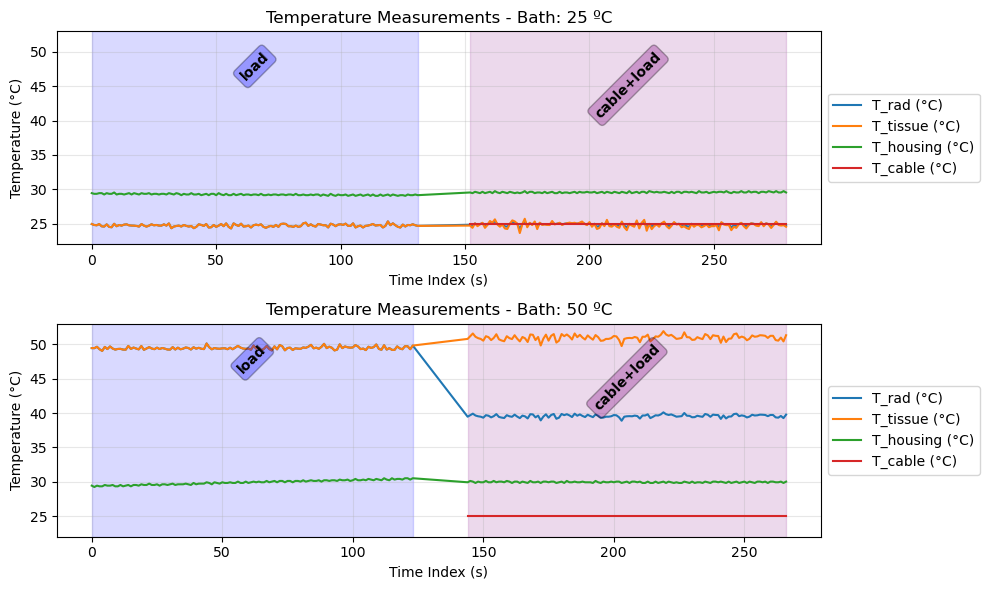

In [40]:
# Define class order and colors
class_order = ['load', 'cable+load']
class_colors = {
    'load': 'blue',
    'cable+load': 'purple',

}

# Define voltage variables to plot
variables = ['T_rad', 'T_tissue', 'T_housing', 'T_cable']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_rad': 'T_rad (°C)',
    'T_cable': 'T_cable (°C)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(5 * len(conditions), 6))
axes[0].set_ylim(22, 53)
axes[1].set_ylim(22, 53)
plt.ylim(22, 53)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Temperature Measurements - Bath: {condition} ºC")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()

In [32]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 25
Microvolts:
            T_rad  T_housing  T_tissue
class                                 
cable+load   24.9       29.6      25.2
load         24.7       29.2      24.7
------------------------------

Condition: 50
Microvolts:
            T_rad  T_housing  T_tissue
class                                 
cable+load   39.6       29.9      51.4
load         49.5       29.9      49.5
------------------------------


## Determining T_cable and Cable Loss from the data

In [33]:
avg_T_rad_25 = all_X_clean[(all_X_clean['condition'] == '25') & (all_X_clean['class'] == 'cable+load')]['T_rad'].mean()
avg_T_rad_50 = all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+load')]['T_rad'].mean()

print(f"Average T_rad for condition 25, class cable+load: {avg_T_rad_25:.2f} °C")
print(f"Average T_rad for condition 50, class cable+load: {avg_T_rad_50:.2f} °C")

Average T_rad for condition 25, class cable+load: 24.89 °C
Average T_rad for condition 50, class cable+load: 39.58 °C


In [34]:
T_bath_cold = 25
T_bath_hot = 50 
CL_empirical = - ((avg_T_rad_50 - avg_T_rad_25) - (T_bath_hot - T_bath_cold)) / (T_bath_hot - T_bath_cold)
print(f"Empirical Cable Loss (CL_empirical): {CL_empirical:.4f}")
print(f"Percentage change in Cable Loss: {((CL_empirical - CL) / CL * 100):.2f}%")

Empirical Cable Loss (CL_empirical): 0.4122
Percentage change in Cable Loss: -6.11%


In [36]:
Tcable_empirical = (avg_T_rad_50 - (1 - CL_empirical) * T_bath_hot) / CL_empirical
print(f"Empirical T_cable (Tcable_empirical): {Tcable_empirical:.2f} °C")
print(f"Percentage change in T_cable: {((Tcable_empirical - T_cable) / T_cable * 100):.2f}%")

Empirical T_cable (Tcable_empirical): 24.72 °C
Percentage change in T_cable: 0.91%


In [37]:
for cond in conditions:
    for class_name in ["load", "cable+load"]:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable+load":
            # T_cable = 23.7 if cond == "25" else 24.7
            # T_cable = 23.7 
            T_cable = Tcable_empirical
            T_tissue = T_tissue_cable_func(T_rad, T_cable, CL_empirical)
        elif class_name in ["load"]:
            T_cable = None
            T_tissue = T_rad
        
        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable


Condition 25 - Data summary by class:
  load: 132 points, time range: 0.0 - 131.0 s
  cable+load: 128 points, time range: 152.0 - 279.0 s

Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  cable+load: 123 points, time range: 144.0 - 266.0 s


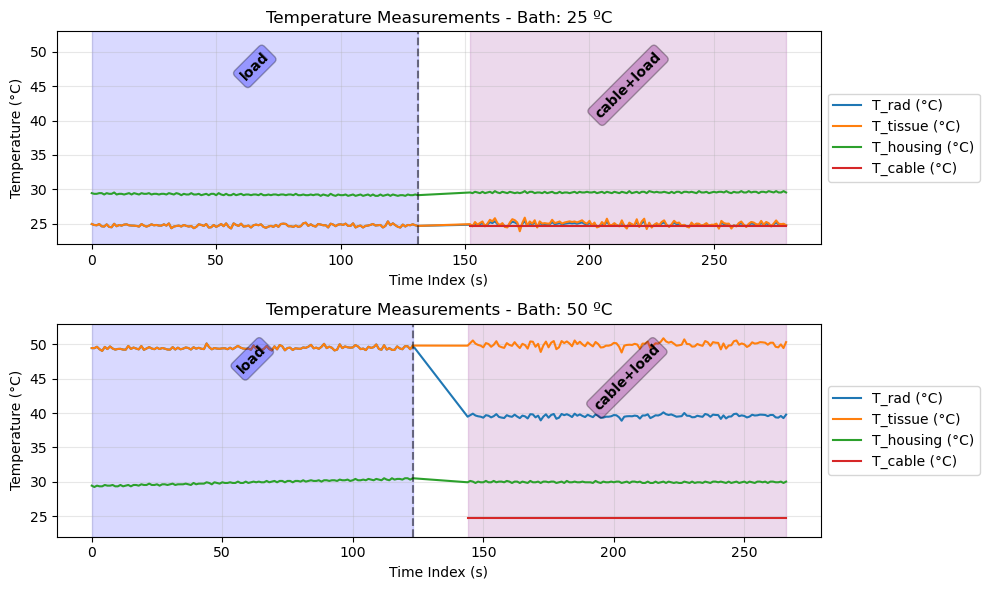

In [38]:
# Define class order and colors
class_order = ['load', 'cable+load']
class_colors = {
    'load': 'blue',
    'cable+load': 'purple',

}

# Define voltage variables to plot
variables = ['T_rad', 'T_tissue', 'T_housing', 'T_cable']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_rad': 'T_rad (°C)',
    'T_cable': 'T_cable (°C)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(5 * len(conditions), 6))
axes[0].set_ylim(22, 53)
axes[1].set_ylim(22, 53)
plt.ylim(22, 53)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add vertical line at the end of each class (except the last one)
            if class_name != available_classes[-1]:
                ax.axvline(class_end, color='black', linestyle='--', alpha=0.5)
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Temperature Measurements - Bath: {condition} ºC")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()

In [63]:
0.4 / 0.54

0.7407407407407407